<a href="https://colab.research.google.com/github/Egeny-aa/Deep_Learning/blob/main/Kagle_competitions/HUBMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Задача соревнования https://www.kaggle.com/competitions/hubmap-organ-segmentation обучить алгоритм, который сегментирует лимфоузлы некоторых человеческих органов

In [11]:
! mkdir ~/.kaggle # Создать каталог с именем “.kaggle”:
! cp kaggle.json ~/.kaggle/ # Скопировать файл “kaggle.json” в созданный каталог:
! chmod 600 ~/.kaggle/kaggle.json #Назначить необходимое разрешение для этого файла 

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! kaggle competitions download -c hubmap-organ-segmentation

100% 5.77G/5.78G [01:13<00:00, 123MB/s]
100% 5.78G/5.78G [01:13<00:00, 84.4MB/s]


In [13]:
! ls / hubmap-organ-segmentation.zip

hubmap-organ-segmentation.zip

/:
bin	 dev   lib32   mnt			 python-apt  srv    usr
boot	 etc   lib64   NGC-DL-CONTAINER-LICENSE  root	     sys    var
content  home  libx32  opt			 run	     tmp
datalab  lib   media   proc			 sbin	     tools


In [ ]:
! unzip hubmap-organ-segmentation.zip -d/Data_comp

In [ ]:
! ls /Data_comp

In [ ]:
!pip install segmentation-models-pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
# !pip install -U albumentations

In [17]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
from google.colab.patches import cv2_imshow
import torch 
from torchvision import transforms
from  torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.backends.cudnn as cudnn
from sklearn.model_selection import train_test_split

from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, RandomRotate90, Compose, GaussNoise, GridDistortion)

import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau

from albumentations import (HorizontalFlip, Normalize, Compose, GaussNoise, RandomRotate90, Transpose)
from albumentations.pytorch import ToTensorV2


import time

seed = 42
np.random.seed(seed)
if torch.cuda.is_available():
  torch.cuda.manual_seed(seed) # Устанавливает каждый одно и тоже случайно число для генерации СЧ на GPU
  torch.manual_seed(seed) # Устанавливает в торче одно и тоже число для генерации СЧ
  torch.backends.cudnn.deterministic = True # Заставляет работать Cudnn c детерминированными алгоритмыми свертки, то есть алгоритмы,
# которые при одних и тех же входных данных и при запуске на одном и том же программном и аппаратном обеспечении всегда дают один и тот же результат.


In [18]:
train_csv_data = pd.read_csv('/Data_comp/train.csv') # Столбец Rle Копия анатационного(json) 
test_csv_data = pd.read_csv('/Data_comp/test.csv')
path_img = '/Data_comp/train_images' 

In [19]:
total_w, total_h = train_csv_data[['img_height','img_width']].value_counts().to_frame().index[0]

In [20]:
train_image_list = os.listdir('/Data_comp/train_images')
train_annotation = os.listdir('/Data_comp/train_annotations')

Запускать до


In [ ]:
train_csv_data.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


In [ ]:
train_csv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 27.5+ KB


В датасете отсутствуют Nan-значения

Следовательно он в очистке не нуждается

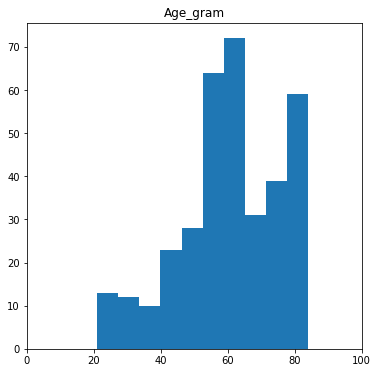

In [ ]:
plt.figure(figsize = (6,6))
plt.title("Age_gram")
plt.hist(train_csv_data.age)
plt.xlim(0,100)
plt.show()

In [ ]:
img_name = Image.open('/Data_comp/train_images/' + train_image_list[0])

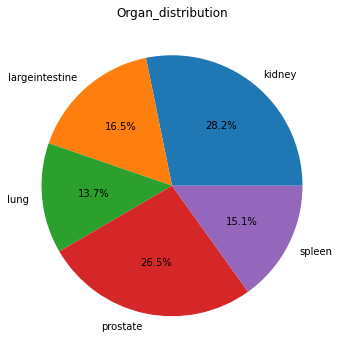

In [ ]:
labels = np.array(train_csv_data.groupby(['organ']).count()['id'].index)
data_organ = np.array(train_csv_data.groupby(['organ']).count()['id'])
plt.figure(figsize = (6,6))
plt.title('Organ_distribution')
plt.pie(data_organ, labels = labels, autopct = '%1.1f%%')
plt.show()

In [ ]:
 train_csv_data[['img_height','img_width']].value_counts().to_frame()

,,0
img_height,img_width,
3000,3000,326
2764,2764,2
2942,2942,2
2631,2631,2
2654,2654,2
2790,2790,2
2416,2416,2
2308,2308,1
2869,2869,1


In [ ]:
train_csv_data['data_source'].value_counts().to_frame()

,data_source
HPA,351


In [ ]:
train_csv_data['pixel_size'].value_counts().to_frame()

,pixel_size
0.4,351


In [ ]:
train_csv_data['tissue_thickness'].value_counts().to_frame()

,tissue_thickness
4,351


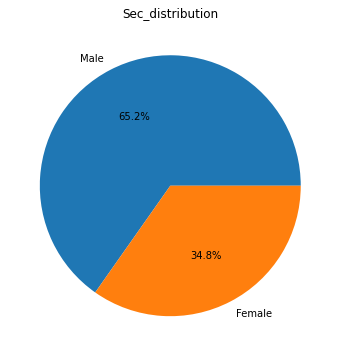

In [ ]:
plt.figure(figsize = (6,6))
label = np.array(train_csv_data['sex'].value_counts().index)
plt.pie(train_csv_data['sex'].value_counts(),labels=label, autopct = '%1.1f%%')
plt.title("Sec_distribution")
plt.show()

Из диаграмм, полученных выше можно сделать вывод, что распределение классов в датасете неравномерное. 

Но так как мы работаем с лимфоузлами, непосредственно с фотосрезом некоторого органа человека, то скорее всего эта несбалансированность нам не помешает разработать алгоритм, сегментирующий изображения

Примем это за факт

Запускать отсюда


In [ ]:
def open_img(img_tr, ann_tr, num_img):
  indices = np.random.choice(np.arange(len(img_tr)), num_img, False)

  fig = plt.figure(figsize =(16,16) )
  for i in range(num_img):
    im_t = Image.open( '/Data_comp/train_images/' + img_tr[i])
    fig.add_subplot(1, num_img, i + 1)
    plt.imshow(im_t)
    plt.axis('off')
    plt.show()
    
open_img(train_image_list, train_annotation, 4)

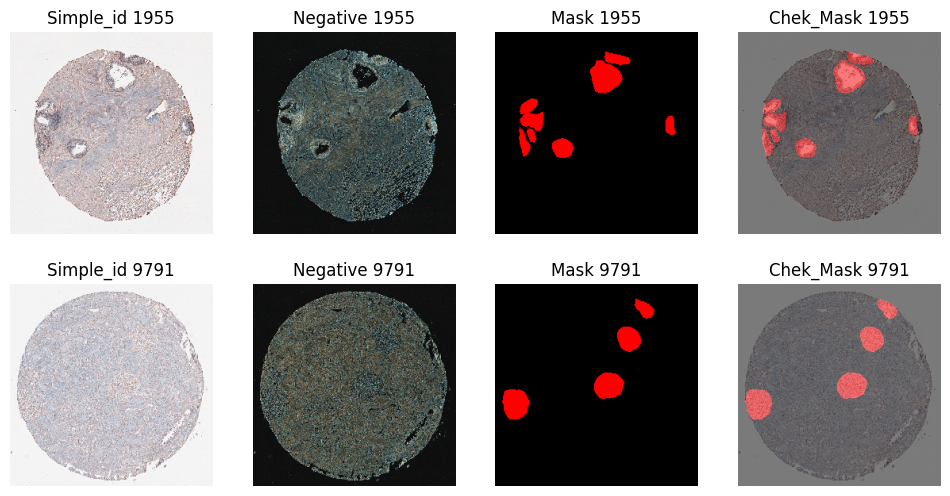

In [ ]:
def open_img(num_imgs):
  # Выводим изображение, его нормализированное состояние, маску т как изображние выглядит на маске 
  indices = np.random.randint(1, len(train_image_list), size = num_imgs)
  fig, ax = plt.subplots(nrows = num_imgs, ncols = 4, figsize= (num_imgs * 6, 6))
    
  for r in range(num_imgs):

    row_id = train_csv_data.iloc[indices[r]].id.squeeze()

    img =  get_img(row_id, 256, 256)   
    
    ax[r,0].imshow(img)
    ax[r,0].set_title(f'Simple_id {row_id}')
    ax[r,0].axis(False)

    neg_img = get_img(row_id,256,256, True)

    ax[r,1].imshow(neg_img)
    ax[r,1].set_title(f'Negative {row_id}')
    ax[r,1].axis(False)

    mask = polug_mask(row_id, 256, 256)

    ax[r,2].imshow(mask * np.array([255,0,0], dtype = np.uint8()))
    ax[r,2].set_title(f'Mask {row_id}')
    ax[r,2].axis(False)

    ax[r,3].imshow(img)
    ax[r,3].imshow(mask * np.array([255,0,0], dtype=np.uint8()), alpha = 0.5 )
    ax[r,3].set_title(f'Chek_Mask {row_id}')
    ax[r,3].axis(False)
  plt.show()

open_img(4)

Изображения выше подкрепляют наши рассуждения о том, что нам неважно в каком из органов расположен лимфоузел

Почти все наши изображения имеют размерность 3000 * 3000 * 3, что дает нам в случаем первого сверточного слоя без paddin, с шагом 2 и размером 2 изображение с H == W == 1500 и некоторой глубиной выхода dout
Что дает нам 2 * 2 * 3 * 1500 * 1500 * dout операций(прим минимальном d - 21 млн) на первом слое, что довольно много. А ресурсы у гугл коллаб не вечные
Поэтому ресайзнем изображение до привычных нейросетям 256 * 256.
Можно и до другого размера, но важно, что H, W должны быть кратны 32. Иначе в первых слоях свертки кодера получится нецелое число пикселей, а это неприемлемо.



In [21]:
def resize_img(tensor, input_h = 256, input_w = 256):
  # Меняем размер изображения используя кубическую интерполмцию
  # Из - за свой свертики размер долен быть кратен 32
  return cv2.resize(tensor, [input_h, input_w], interpolation = cv2.INTER_CUBIC)

def polug_mask(img_id, img_h = 256, img_w = 256):
  # Отрисовывыем маску
  row = train_csv_data.query(f'id == {img_id}').squeeze() # Выбираем строку из датасета
  img_height, img_width = row.img_height, row.img_width #Высота и ширина датасета
  polugon = row.rle.split() # Список пикселей(Начальный, длина дорожки), который является маской
  mask = np.zeros([img_height * img_width ], dtype = np.uint8()) # Создаем одномерную маску из 0
  
  start = np.array([int(x) for x in polugon[0::2]]) #Выбираем начало каждого пикселя в маске
  lenght = np.array([int(x) for x in polugon[1::2]]) #Выбираем Длину дорожки

  for st,en in zip(start, lenght):
    mask[st: st + en + 1] = 1 # Нужным пикселям - 1

  mask = mask.reshape(img_height, img_width).T # Делаем двумерное представление маски
  mask = resize_img(mask, img_h, img_w) # Ресайзим маску
  mask = np.expand_dims(mask, axis = 2) # Изображение имеет трехмерную размерность -> а Маска принадлежность 2 классам 1 и 0 -> двумерный массив с 1 каналом
  
  return mask

def get_img(img_id, img_h = 256, img_w = 256, neg = False):
  img = cv2.imread(f'/Data_comp/train_images/{img_id}.tiff')      
  img = resize_img(img, img_h, img_w)

  if neg: # Нормализуем изображение, если стоит соответствующий флаг
    img = img - img.min()
    img = img / (img.max() - img.min())
    img = img * 255
    img = 255 - img.astype(np.uint8())

  return img

In [22]:
class lim_ysels(Dataset):
  """Класс для инициализации данных, их аугументации, и перебора для Loader"""
  def __init__(self, csv_set, transforms = False):
    self.csv_set = csv_set
    self.transforms = transforms

  def __len__(self):
    return len(self.csv_set)

  def __getitem__(self, index):

    if torch.is_tensor(index):
      index = index.tolist()

    row = self.csv_set.iloc[index]
    img_id = row.id

    img = get_img(img_id)
    mask = polug_mask(img_id)
    
    if self.transforms:
      augmentation = self.transforms(image = img, mask = mask)
      aug_img = augmentation['image']
      aud_mask = augmentation['mask']

    # Перевод изображений в тензор обязателен для обучения NC, производиться в ручною без ToTensor()
    image = aug_img.transpose(2, 0, 1)
    mask = aud_mask.transpose(2, 0, 1)

    image_tensor = torch.from_numpy(image.astype(np.float32))
    mask_tensor = torch.from_numpy(mask.astype(np.float32))


    return image_tensor, mask_tensor

In [174]:
def choice_set(ds, train = True):
  # Разбиваем датасет на трнировочный и валидационный 80 и 20
 
  train_ds, val_ds = train_test_split(ds, test_size = 0.2, random_state = seed)
  transform_list = [Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
 
  # Если Датасет тренировочный, то добавляем к нему аугументацию данных
  if train:
    #transform_list = transform_list + [HorizontalFlip(p = 0.5), GridDistortion(p = 0.5),Transpose(p = 0.5), RandomRotate90(p=0.5), GaussNoise(per_channel = True)]
    return lim_ysels(train_ds, transforms = Compose(transform_list))
  
  else:
    return lim_ysels(val_ds, transforms = Compose(transform_list))

In [175]:
batch_size = 16
train_df = choice_set(train_csv_data)
val_df = choice_set(train_csv_data, train = False)

 
train_loader = DataLoader(train_df, batch_size = batch_size, shuffle = True, generator=torch.Generator(device='cuda')) 
val_loader = DataLoader(val_df, batch_size = batch_size * 2, shuffle = True, generator=torch.Generator(device='cuda'))

Напишем функцию для вычисления метрики Dice 

Так же класс для храниния истории лосса и коэфицента Dice

In [25]:
def Dice_score(target, predict, treshold = 0.2): 
  predict = (predict > treshold).float()
  Dice = 2 * (predict * target).sum() / (predict + target).sum()
  return Dice



class Scores():
  """Класс инициализирующий объект в котором хранится метрика Dice, посчитанная по всем эпохам."""
  def __init__(self):
    self.epoch_train_Dice = {}
    self.epoch_val_Dice = {}
    self.bach_Dice = [] 
    self.tr_ep = 1
    self.val_ep = 1

  def upDice(self, target, predict, treshold = 0.2):
    """Обновляем коэфицент"""
    dice = Dice_score(target, predict, treshold)
    self.bach_Dice.append(dice) 


  def get_metric(self, stage):
    """Получаем среднюю метрику по эпохе и добавляем коэфицент в тот или иной словарь,
     в зависимости от стадии обучения"""
    dice = np.mean(self.bach_Dice)
    
    if stage == 'Val':
      self.epoch_val_Dice[self.val_ep] = dice
      self.val_ep += 1
    else:
      self.epoch_train_Dice[self.tr_ep] = dice
      self.tr_ep += 1
    
    return dice

  def delate_epoch(self):
    """Очищаем коэфиценты, накопленные за всю эпоху """
    self.bach_Dice = []

  def get_epoch_Dice(self):
    """Возвращаем средний Dice за всю эпоху"""
    return  self.epoch_Dice


Обучим как с комбинированным лоссом, так и с обычным.

In [26]:
def binery_combine_loss(loss1, loss2, pred,true, alpha = 0.5, betta = 0.5): 
  return alpha * loss1(pred, true) + betta * loss2(pred, true)


Напишем класс для тренировки НС

In [111]:
class Trainer(object):
  '''Класс Trainer используется для обучения и тестирования нейроной сети
    имеет функции:
    forward - делает прямой проход по нейронной сети
    train_iter - делает итерацию на которой нейроная сеть обучается
    val_iter - делает итерацию на которой нейроная сеть тестируется в рамках отложенной выборки
    start_learn - начинает обучение нейроной сети и при уменьшении функции потерь на валидационной выборке сохраняет параметры в локальную папку'''

  def __init__(self, model, loss, train_loader, val_loader, optim, shelder, epochs):
    """Инициализация модели и её параметров"""
    self.model = model
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.optim = optim  
    self.shelder = shelder   
    self.epochs = epochs
    self.loss_Train_history = []
    self.loss_Val_history = []
    self.best_loss = float('inf')
    self.score_class = Scores()
    self.val_predicted = {}

    if torch.cuda.is_available():
      self.device = torch.device('cuda:0') 
  
      torch.set_default_tensor_type("torch.cuda.FloatTensor") # Задача типа тензора, который будет использоваться по умолчанию на графическом процессоре 
      cudnn.benchmark= True # Заставляет выбирать только самые быстрые алгоритмы свертки
    else:
      self.device = self.device("cpu")
    
    self.loss = loss
    self.net = model.to(self.device) 
    
  def forward(self, img, mask):
    
    img_gpu = img.to(self.device, dtype = torch.float)
    mask_gpu = mask.to(self.device, dtype = torch.float)

    predict_mask = self.net(img_gpu)
   
    losses = binery_combine_loss(self.loss['loss1'], self.loss['loss2'], predict_mask, mask_gpu, self.loss['alpha'], self.loss['betta'])
    #losses = self.loss(predict_mask, mask_gpu) - если выбираем некомбинированную лосс
 
    return losses, predict_mask

  def train_iter(self, epoch, metrick_class):
    start_time = time.strftime("%H:%M:%S")

    total_epoch_loss = 0
    self.net.train() 
    for iter, bach in enumerate(self.train_loader):
      img, mask = bach
      
      self.optim.zero_grad()
      losses, predict = self.forward(img, mask)
      losses.backward()  
    
      self.optim.step() 
      total_epoch_loss += losses.item() 
      predict = predict.detach().cpu() 
      metrick_class.upDice(mask, predict, treshold = 0.5)

    losses = losses / len(self.train_loader)
    get_dice = metrick_class.get_metric('Train')
    print('Loss | %0.3f Dice | %0.3f' % (losses, get_dice) )
    self.loss_Train_history.append(float(losses.cpu().detach().numpy()))
    
    metrick_class.delate_epoch()
    end_time = time.strftime('%H:%M:%S')
    print(f"Start Train: {start_time}, Epoch - {epoch + 1}, End train{end_time}")
    return losses

  def val_iter(self,epoch, metrick_class):
    total_loss = 0
    self.net.eval()
    count = 0
    for iter, bach in enumerate(self.val_loader):
      img, mask = bach
      losses, pred = self.forward(img, mask)

      total_loss += losses.item()
      pred = pred.detach().cpu()
      metrick_class.upDice(mask, pred)
      
    losses = total_loss / len(self.val_loader)
    get_dice = metrick_class.get_metric('Val')
    metrick_class.delate_epoch()
    self.loss_Val_history.append(float(losses))
    print('Val_loss | %0.3f, Val_dice | %0.3f' % (losses, get_dice))
    return losses, pred, mask

  def start_learn(self):

    for ep in range(self.epochs):
      loss = self.train_iter(ep, self.score_class)
      

      state = {
                "epoch": ep,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(), #Сохраняем параметры нейросетки (веса) и отступы(bias) в словарь
                "optimizer": self.optim.state_dict(), # Сохраняем параметры оптимизатора в словарь
            }

      with torch.no_grad():

        val_loss, val_pred_mask, mask = self.val_iter(ep, self.score_class)
        
        self.val_predicted[ep]  = (val_pred_mask[0], mask[0])
        self.shelder.step()
        if val_loss < self.best_loss:
          print("******** New optimal found, saving state ********")
          self.best_loss = val_loss
          state['best_loss'] = val_loss
          torch.save(state['state_dict'], '/content/drive/MyDrive/Models_parm/U_NET_par')
          torch.save(state,'/content/drive/MyDrive/Models_parm/Med_segment')
  

In [ ]:
model_1 = smp.Unet(encoder_name="resnet50", 
                 encoder_weights="imagenet", 
                 in_channels=3, 
                 classes=1)

model_2 = smp.DeepLabV3(encoder_name="resnet50", 
                 encoder_weights="imagenet", 
                 in_channels=3, 
                 classes=1)

In [177]:
def choice_params_for_learning(model): # Реализация Random Search
  lr = np.random.uniform(1e-2, 5e-4)
  betas_uni = np.random.uniform(0.6, 0.99)
  betas = (betas_uni, betas_uni + 0.009) 
  eps = np.random.uniform(1e-7, 1e-9)
  wight_decay = np.random.uniform(lr * 0.01, lr * 0.05)


  optimazer = np.random.choice([optim.Adam(model.parameters(),lr=lr, betas = betas, eps=eps, weight_decay = wight_decay, capturable = True),
                                torch.optim.AdamW(model.parameters(),lr=lr, betas = betas, eps=eps, weight_decay = wight_decay, capturable = True)])
  
  gamma = np.random.uniform(0.5, 0.95)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimazer, gamma=gamma, verbose=False)


  return optimazer, scheduler 



In [67]:
class Search_best_model():
  """Класс, реализованный для выбора лучших ГП для выбранной модкли НС.
     Хранит историю обучения всех моделей
  """
  def __init__ (self, num_model, model, loss, train_loader,val_loader,num_epoch):
    self.num_model = num_model
    self.model = model
    self.loss = loss
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.num_epoch = num_epoch
    self.models_train_objct = {}

  def start_train_models(self):
    
    for i in range(1, self.num_model + 1):
      optim, shel = choice_params_for_learning(self.model)  
      train = Trainer(self.model, self.loss, self.train_loader, self.val_loader, optim, shel, self.num_epoch)
      train.start_learn()
      self.models_train_objct[i] = train



In [ ]:
# Search_best_model -> .model_tarin_objct[i] -> .score_class -> Train + Val loss_history + Коэфицен Дайс по каждой эпохе + коэфицент дайс по всем эпохам и это все для каждой моодели

In [178]:
# Обучение заняло 2ч 55 мин
MODEL_COUNT = 10
EPOCH_COUNT = 10
loss = {'loss1': smp.losses.SoftBCEWithLogitsLoss(), 'loss2': smp.losses.DiceLoss('binary'), 'alpha': 0.5 , 'betta': 0.5}
search_model = Search_best_model(EPOCH_COUNT, model_1, loss, train_loader, val_loader, MODEL_COUNT)
search_model.start_train_models()

Loss | 0.029 Dice | 0.000
Start Train: 13:30:26, Epoch - 1, End train13:31:50
Val_loss | 0.707, Val_dice | 0.325
******** New optimal found, saving state ********
Loss | 0.030 Dice | 0.000
Start Train: 13:32:15, Epoch - 2, End train13:33:32
Val_loss | 0.540, Val_dice | 0.000
******** New optimal found, saving state ********
Loss | 0.030 Dice | 0.015
Start Train: 13:33:55, Epoch - 3, End train13:35:12
Val_loss | 0.698, Val_dice | 0.298
Loss | 0.027 Dice | 0.141
Start Train: 13:35:30, Epoch - 4, End train13:36:47
Val_loss | 0.490, Val_dice | 0.372
******** New optimal found, saving state ********
Loss | 0.024 Dice | 0.225
Start Train: 13:37:09, Epoch - 5, End train13:38:26
Val_loss | 0.568, Val_dice | 0.413
Loss | 0.028 Dice | 0.260
Start Train: 13:38:44, Epoch - 6, End train13:39:58
Val_loss | 0.458, Val_dice | 0.327
******** New optimal found, saving state ********
Loss | 0.027 Dice | 0.278
Start Train: 13:40:20, Epoch - 7, End train13:41:36
Val_loss | 0.484, Val_dice | 0.181
Loss | 0.

In [179]:
model_train_loss = []
model_val_loss = []

for i in range(MODEL_COUNT):
  model_train_loss.append(search_model.models_train_objct[i + 1].loss_Train_history)
  model_val_loss.append(search_model.models_train_objct[i + 1].loss_Val_history)

In [ ]:
def present_model_train_score(model_train_loss, model_val_loss,MODEL_COUNT):
  fig, ax = plt.subplots(nrows = MODEL_COUNT, ncols = 2, figsize = (10, 4 * MODEL_COUNT))

  for r in range(MODEL_COUNT):

    ax[r, 0].plot(model_train_loss[r], color='red')
    ax[r, 1].plot(model_val_loss[r], color='darkred')

    ax[r, 0].set_title(f'Train_history of traning {r + 1} model')
    ax[r, 1].set_title(f'Val_history of traning {r + 1} model')
  plt.show()


In [ ]:
def model_visual_traning_history(model_val_mask_img, EPOCH_COUNT):

  fig, ax = plt.subplots(nrows = EPOCH_COUNT, ncols = 2, figsize = (3,EPOCH_COUNT * 2))

  for c in range(EPOCH_COUNT):
    
    ax[c,0].imshow(model_val_mask_img[c][0].reshape(256,256,1))
    ax[c,0].axis(False)
    ax[c,0].set_title('Val')

    ax[c,1].imshow(model_val_mask_img[c][1].reshape(256,256,1))
    ax[c,1].axis(False)
    ax[c,1].set_title('Grd_true')
  plt.show()

Ниже представлены графики обучения 10 нейронных сетей U-net на датасете без аугументационных данных

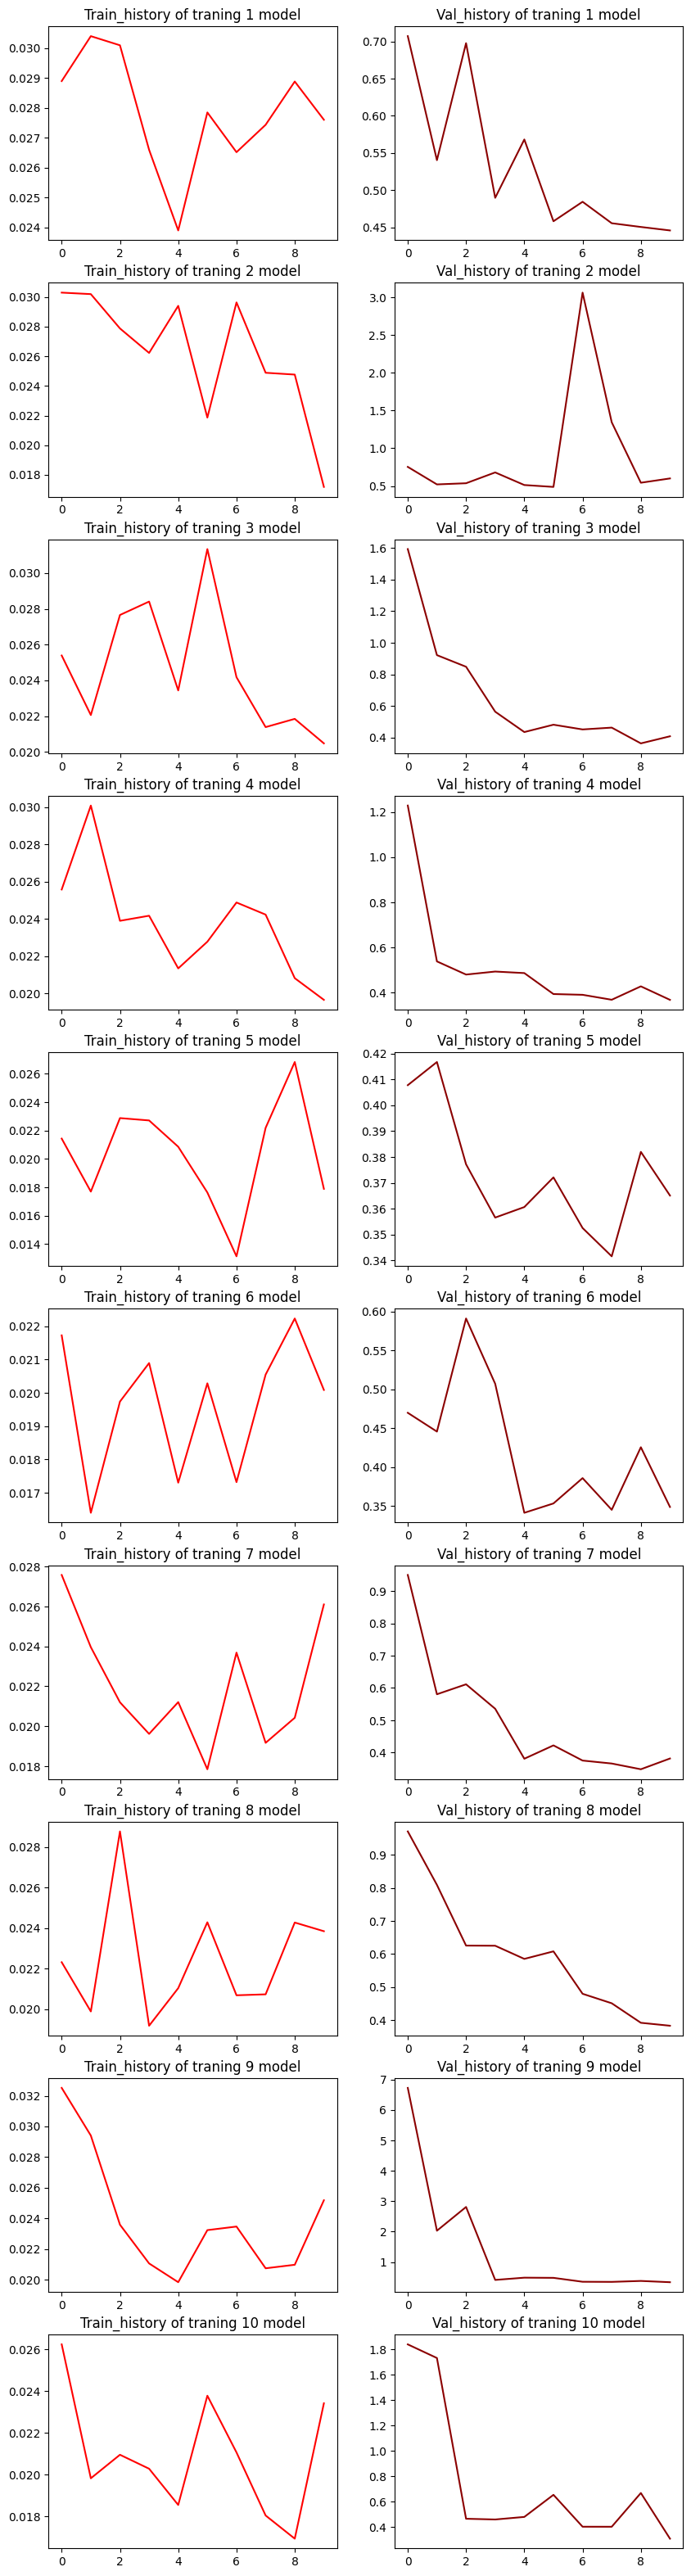

In [186]:
present_model_train_score(model_train_loss, model_val_loss, MODEL_COUNT)

По графикам обучения можно сказать, что модели 4, 8, 3 можно дообучить.

С их гиперпарамтрами обучение проходило гладко, без скачков

Ниже представлены предсказанные нашей сетью сегментационные маски на валидационном датасете. Мне кажется, что нужно подобрать некоторый порог бинаризации. Видно, что нейронная сеть что-то выучила, но совсем не идеально. Есть такие изображения, где все замазано желтым, а сегментируемых объект очень мал.
Лучше всех, как мне кажется справляется с задачей нейронная сеть №8. Дообучать будем ее

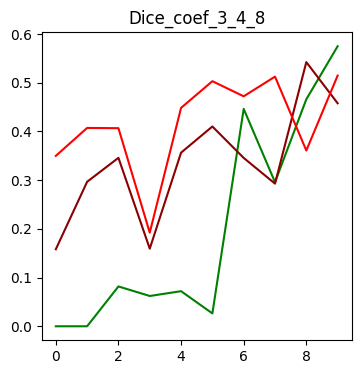

In [199]:
plt.figure(figsize = (4,4))
plt.plot(search_model.models_train_objct[8].score_class.epoch_val_Dice.values(),color='green')
plt.plot(search_model.models_train_objct[3].score_class.epoch_val_Dice.values(), color='darkred')
plt.plot(search_model.models_train_objct[4].score_class.epoch_val_Dice.values(), color='red')
plt.title('Dice_coef_3_4_8')
plt.show()

Как видно из графиков, коэфициент Dice самый высокий у модели под номером 8

Dice = 0.575

In [193]:
search_model.models_train_objct[8].optim.state_dict()['param_groups'] # параметры обучения 8 модели

[{'lr': 0.001371667751309433,
  'betas': (0.605491130858883, 0.614491130858883),
  'eps': 8.031460199520828e-08,
  'weight_decay': 0.0027732263300247126,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': True,
  'differentiable': False,
  'fused': None,
  'initial_lr': 0.007211862340178638,
  'params': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   

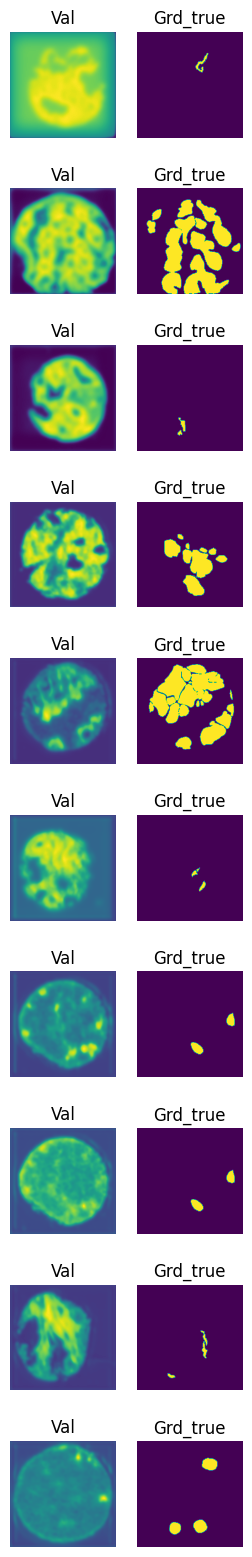

In [183]:
model_visual_traning_history(search_model.models_train_objct[3].val_predicted, EPOCH_COUNT)

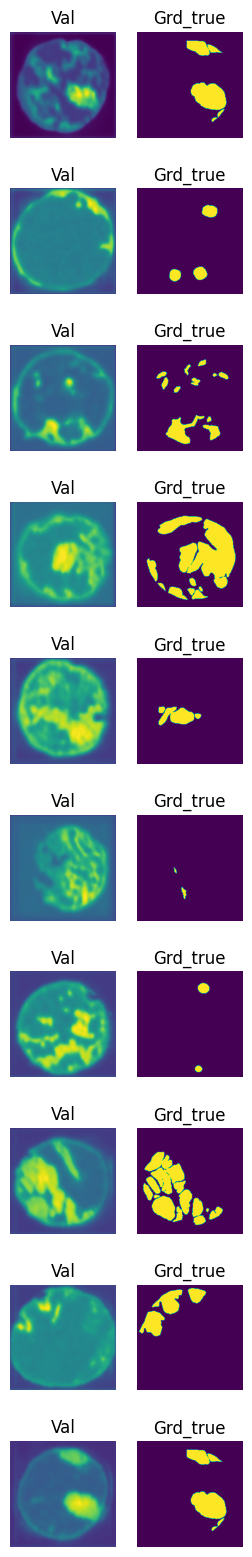

In [184]:
model_visual_traning_history(search_model.models_train_objct[4].val_predicted, EPOCH_COUNT)

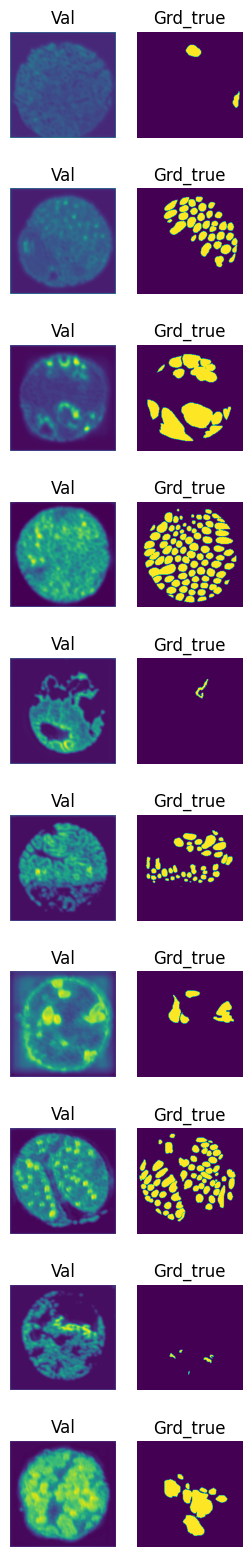

In [185]:
model_visual_traning_history(search_model.models_train_objct[8].val_predicted, EPOCH_COUNT)

In [200]:
def choice_set(ds, train = True):
  # Разбиваем датасет на трнировочный и валидационный 80 и 20
 
  train_ds, val_ds = train_test_split(ds, test_size = 0.2, random_state = seed)
  transform_list = [Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]
 
  # Если Датасет тренировочный, то добавляем к нему аугументацию данных
  if train:
    transform_list = transform_list + [HorizontalFlip(p = 0.5), GridDistortion(p = 0.5),Transpose(p = 0.5), RandomRotate90(p=0.5), GaussNoise(per_channel = True)]
    return lim_ysels(train_ds, transforms = Compose(transform_list))
  
  else:
    return lim_ysels(val_ds, transforms = Compose(transform_list))

In [201]:
batch_size = 16
train_df = choice_set(train_csv_data)
val_df = choice_set(train_csv_data, train = False)

 
train_loader = DataLoader(train_df, batch_size = batch_size, shuffle = True, generator=torch.Generator(device='cuda')) 
val_loader = DataLoader(val_df, batch_size = batch_size * 2, shuffle = True, generator=torch.Generator(device='cuda'))

In [202]:
optimazer = search_model.models_train_objct[8].optim
model = search_model.models_train_objct[8].model
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimazer, gamma=0.85, verbose=True)
loss = {'loss1': smp.losses.SoftBCEWithLogitsLoss(), 'loss2': smp.losses.DiceLoss('binary'), 'alpha': 0.5 , 'betta': 0.5}

train = Trainer(model, loss, train_loader, val_loader, optimazer, scheduler, 10)
train.start_learn()

Adjusting learning rate of group 0 to 1.3717e-03.
Loss | 0.033 Dice | 0.280
Start Train: 17:04:39, Epoch - 1, End train17:06:06
Val_loss | 0.743, Val_dice | 0.096
Adjusting learning rate of group 0 to 1.1659e-03.
******** New optimal found, saving state ********
Loss | 0.029 Dice | 0.312
Start Train: 17:06:34, Epoch - 2, End train17:08:02
Val_loss | 0.708, Val_dice | 0.106
Adjusting learning rate of group 0 to 9.9103e-04.
******** New optimal found, saving state ********
Loss | 0.024 Dice | 0.366
Start Train: 17:08:28, Epoch - 3, End train17:09:55
Val_loss | 0.458, Val_dice | 0.351
Adjusting learning rate of group 0 to 8.4238e-04.
******** New optimal found, saving state ********
Loss | 0.028 Dice | 0.368
Start Train: 17:10:21, Epoch - 4, End train17:11:50
Val_loss | 0.698, Val_dice | 0.026
Adjusting learning rate of group 0 to 7.1602e-04.
Loss | 0.028 Dice | 0.310
Start Train: 17:12:11, Epoch - 5, End train17:13:37
Val_loss | 0.509, Val_dice | 0.239
Adjusting learning rate of group 0 

In [203]:
train.start_learn()

Loss | 0.028 Dice | 0.312
Start Train: 17:23:19, Epoch - 1, End train17:24:46
Val_loss | 0.353, Val_dice | 0.568
Adjusting learning rate of group 0 to 2.2954e-04.
******** New optimal found, saving state ********
Loss | 0.027 Dice | 0.352
Start Train: 17:25:11, Epoch - 2, End train17:26:36
Val_loss | 0.331, Val_dice | 0.579
Adjusting learning rate of group 0 to 1.9511e-04.
******** New optimal found, saving state ********
Loss | 0.029 Dice | 0.348
Start Train: 17:27:02, Epoch - 3, End train17:28:28
Val_loss | 0.378, Val_dice | 0.453
Adjusting learning rate of group 0 to 1.6584e-04.
Loss | 0.030 Dice | 0.355
Start Train: 17:28:49, Epoch - 4, End train17:30:14
Val_loss | 0.391, Val_dice | 0.395
Adjusting learning rate of group 0 to 1.4097e-04.
Loss | 0.028 Dice | 0.319
Start Train: 17:30:35, Epoch - 5, End train17:32:03
Val_loss | 0.326, Val_dice | 0.616
Adjusting learning rate of group 0 to 1.1982e-04.
******** New optimal found, saving state ********
Loss | 0.028 Dice | 0.363
Start Tra

In [ ]:
train.start_learn()


Loss | 0.021 Dice | 0.359
Start Train: 17:42:19, Epoch - 1, End train17:43:47
Val_loss | 0.354, Val_dice | 0.538
Adjusting learning rate of group 0 to 4.5190e-05.
Loss | 0.024 Dice | 0.341
Start Train: 17:44:08, Epoch - 2, End train17:45:32
Val_loss | 0.355, Val_dice | 0.547
Adjusting learning rate of group 0 to 3.8412e-05.
Loss | 0.024 Dice | 0.306
Start Train: 17:45:52, Epoch - 3, End train17:47:17
Val_loss | 0.343, Val_dice | 0.568
Adjusting learning rate of group 0 to 3.2650e-05.
Loss | 0.026 Dice | 0.315
Start Train: 17:47:37, Epoch - 4, End train17:49:01
Val_loss | 0.303, Val_dice | 0.644
Adjusting learning rate of group 0 to 2.7753e-05.
******** New optimal found, saving state ********
Loss | 0.027 Dice | 0.326
Start Train: 17:49:27, Epoch - 5, End train17:50:54
Val_loss | 0.334, Val_dice | 0.602
Adjusting learning rate of group 0 to 2.3590e-05.
Loss | 0.026 Dice | 0.359
Start Train: 17:51:14, Epoch - 6, End train17:52:36
Val_loss | 0.315, Val_dice | 0.622
Adjusting learning rat

При дообучении на 34 эпохе коэфициент Dice становится равный 0.644 